# Completeness Test - 01
<hr>

Injecting simulated sources with different flux densities at random positions of dirty map in order to study the completeness of selection methods as a function of S/N.

**Oteo et al.**
1. make a range of flux densities (flat distribution), 0.1 to 10mJy, step 0.025mJy
2. inject a source at random position within 1.5 PB
3. change the phasecenter to that position -> object at the center of dirty map -> easy to define same cleaning box for all injected source.
4. do non-interactive cleaning, down to the rms of dirty map
5. repeat from step 2. for 100x for each flux (with different position in the map)
6. repeat for different flux

Note: not using PB correction, same like in the source detection

<hr>
<hr>

Question:
- Completeness test should be different for different image, right?  Oteo did not explain what image they used for completeness test (single or averaging from all images they have)
- Changing it to the center, means that it is different with real condition when extracting the source, right? i.e. the sources are not in the phase center


<hr>
<hr>

**Our method**
1. make a range of flux depend on the RMS of image e.g. 2.5$\sigma$ to 10$\sigma$; _Oteo result: 100% complete at 7$\sigma$_
2. make a grid based on beam size (this define minimum distance between source/grid size/maximum number of source) and also define minimum number of source that we need
3. inject all the samples for 'a value of flux' in the grid
4. Then we can CLEAN all sample for a single value of flux all together (not one by one 100x like in Oteo et al?) -> the phase center is not 'on' the sample-source -> more similar with real case; because it is a define grid then we can easily define a cleaning box based on position that we have too (if needed).
5. repeat from step 3. for different value of flux

with this method we can evaluate completeness test **not only as the function of flux or S/N**, but also as a **function of radius** from the center -> function of primary beam attenuation 


### How?
We will use this kind of method to inject sources / components in the image

+ https://casaguides.nrao.edu/index.php?title=Create_a_Simulated_Image
+ https://casaguides.nrao.edu/index.php/Simulation_Guide_Component_Lists_(CASA_4.3)

### Estimation

On band 6 with PB ~24" and beam size 0.2"

In [1]:
import numpy as np

# example on Band 6
PB = 24.0 # arcsec
beam = 0.2 # arcsec

imagesize = 2*PB
distance_between_source = 10*beam # 10 x beam -> change this value to fine appropriate number

grid = imagesize/(distance_between_source)
number = (grid)**2
print grid, number
grid = int(grid)
print "Grid size : ", grid, "x", grid, "\nTotal number of sample: ", int(number)

24.0 576.0
Grid size :  24 x 24 
Total number of sample:  576


### Generate sample

In [2]:
center = [65.8158364, -1.3425182]
start  = [center[0] - imagesize/(2*3600) + 0.5*distance_between_source/3600.0, 
         center[1] - imagesize/(2*3600) + 0.5*distance_between_source/3600.0]

sample = []
for i in range(grid):
    for j in range(grid):
        sample.append([start[0] + distance_between_source/3600. * i, start[1] + distance_between_source/3600. * j]) 
        # in degree

sample = np.array(sample)

### Try overplot

In [3]:
from astropy import units as u 
from astropy import coordinates
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy

%matplotlib inline

INFO: Setting slices=[0, 0] [aplpy.core]


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

INFO: Setting slices=[0, 0] [aplpy.core]


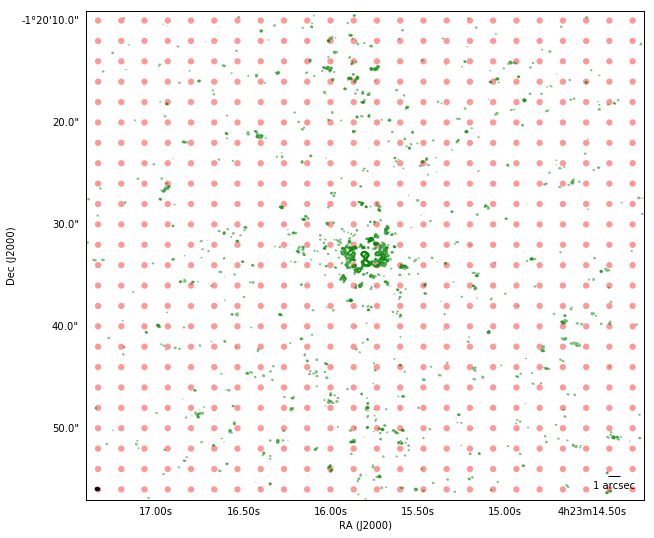

In [4]:
B6 = '../compareImage/images/J0423-0120_B6.fits'
rmsB6 = 3.4E-05

multp = np.array([2.5, 3, 3.5, 4.5, 5, 5.5, 6, 10, 100, 1000, 10000]) # sigma
lvlB6 = rmsB6*multp

fig = aplpy.FITSFigure(B6);
fig.add_beam()
fig.beam.set_color('black')
fig.add_scalebar(1 * u.arcsecond)
fig.scalebar.set_label('1 arcsec')
fig.scalebar.set_color("black")
fig.show_contour(B6, colors='green', levels=lvlB6, alpha=0.5);

## add marker for the position of fake source
fig.show_markers(sample[:,0], sample[:,1], edgecolor='none', facecolor='red', marker='o', s=40, alpha=0.4);

Well done!

### After making sure that the generated sample is in correct position, lets try it in real image in CASA

<hr>
<hr>

Before that, I have some questions:

+ How to justify the injected-source that located in same position with the candidate-source in image? it will influence the completeness test it self, doesn't it?

<font color="blue">S: Yes, but unlikely...</font>

+ Should we use shape = 'Gaussian' or 'Point'? If gaussian, what kind of shape we use, synthesized beam? With or without spectral index? 

<font color="blue">
S: Probably point will be okay since we assume that sources are point-like . We do not consider case of resolved sources which is reasonable. spectral index is not necessary.
</font>

+ If it is point source without spectral index, we don't need to set the 'freq', right?

<font color="blue">
S: I would say no but not 100% sure since you inject in the MS with some frequency.
</font>

+ In the CLEANing after injecting, should we 'mask' every location of injected-source? Oteo et al, make a box-mask in cleaning after changing phasecenter to each injected-source.
-- if needed we can use https://casa.nrao.edu/docs/TaskRef/makemask-task.html or define it directly in Usemask parameter in CLEAN task 

<font color="blue">
S: Uhm, by that we bias a bit the detection... I would do exactly the way you clean for one image.. maybe a general box or better the task ... I would say the important things is not to use a priori information from the sources for the detection... 
</font>

+ we extract the source using SExtractor again, what 'flux' we can use to compare with our injected flux-value. Is it FLUX_BEST? In Oteo et al., they explain about Flux Boosting (comparison between injected and recovered flux), but they don't explain what 'flux' they used.  [*actually we can see later after trying :)] 

<font color="blue">
S: FLUX_BEST is probably good.. but i am not sure about the scale . I thing what I did for the article was to measure a bright source with casaviewer and check the flux from sextractor.
</font>

<font color="blue">
S: Maybe it would be better to avoid the very center because it will be confused with the strong calibrator.  but a small detail for the final competeness.
</font>

<hr>
<hr>

### Making script

Can be found in here.

<hr>
<hr>
**Technical Note:**
- There is <code><span style="color:red">asciitocomponentlist</span></code> in <code>componentlist</code> Toolkit that can be used to add components from ascii file: https://casa.nrao.edu/docs/CasaRef/componentlist.asciitocomponentlist.html
but it is *not implemented* in CASA yet (only in AIPS)

- In astropy, both ICRS and FK5 frame (for same equinox J2000.0) give same result (at least in order of micro arcsec)
- Copy multiple files using scp from Remote to Local:
<pre>scp your_username@remote.edu:/some/remote/directory/\{a,b,c\} ./localdirectory/</pre>
Don't use space after comma!! silly mistake :) 

- Region format in CASA: https://casaguides.nrao.edu/index.php/CASA_Region_Format
<hr>
<hr>

### Result of the first test
<hr>

Only for one value of flux 1.02e-04 Jy (~3$\sigma$ from previus result), with other parameter given above. 

These are the list of rms calculated using imstat, with region to calculated rms defined by: 
<pre>region = 'annulus[[65.8158364deg, -1.3425182deg], [5arcsec, 15arcsec]]'</pre>

| case       | w/o cleaning | cleaning w/o mask | cleaning w/ mask |
|------------|--------------|-------------------|------------------|
| uninjected | 3.702660e-05 | 3.200142e-05      | 3.277763e-05     |
| injected   | 4.120195e-05 | 3.639557e-05      | 3.742764e-05     |

+ **Case 1: Without cleaning**
<pre>in clean --> <code>niter = 0</code></pre>

+ **Case 2: After cleaning without masking**

+ **Case 3: After cleaning with masking centered around central source**
<pre>mask = 'circle[[65.8158364deg, -1.3425182deg], 5arcsec]'</pre>





<hr>

In [5]:
import aplpy

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.069e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.175e-04 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.217e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.345e-04 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.049e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.152e-04 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.190e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.329e-04 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.219e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.482e-04 [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.348e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.590e-04 [aplpy.core]


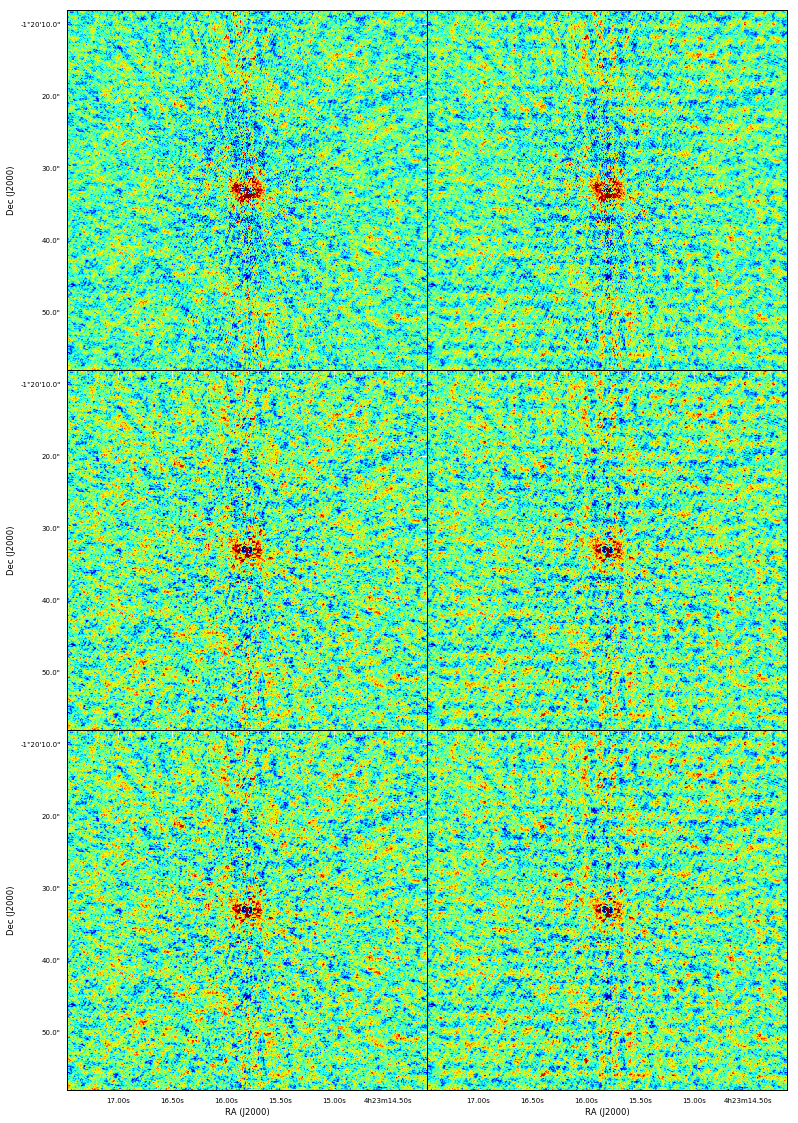

In [6]:
#!beware, each image in here is using different color scale
fig = plt.figure(figsize=(10, 15))

#! from bottom to top
f1 = aplpy.FITSFigure('./images/uninjected.ms.afterclean.withmask.cont.fits', figure=fig, subplot=[0.0,0.0,0.5,0.3333])
f1.set_tick_labels_font(size='x-small'); f1.set_axis_labels_font(size='small')
f1.show_colorscale()

f2 = aplpy.FITSFigure('./images/injected.ms.afterclean.withmask.cont.fits', figure=fig, subplot=[0.5,0.0,0.5,0.3333])
f2.set_tick_labels_font(size='x-small'); f2.set_axis_labels_font(size='small')
f2.hide_yaxis_label(); f2.hide_ytick_labels()
f2.show_colorscale()


f3 = aplpy.FITSFigure('./images/uninjected.ms.afterclean.cont.fits', figure=fig, subplot=[0.0,0.3333,0.5,0.3333])
f3.set_tick_labels_font(size='x-small'); f3.set_axis_labels_font(size='small')
f3.hide_xaxis_label(); f3.hide_xtick_labels()
f3.show_colorscale()

f4 = aplpy.FITSFigure('./images/injected.ms.afterclean.cont.fits', figure=fig, subplot=[0.5,0.3333,0.5,0.3333])
# f4.set_tick_labels_font(size='x-small'); f4.set_axis_labels_font(size='small')
f4.hide_yaxis_label(); f4.hide_ytick_labels()
f4.hide_xaxis_label(); f4.hide_xtick_labels()
f4.show_colorscale()

f5 = aplpy.FITSFigure('./images/uninjected.ms.withoutclean.cont.fits', figure=fig, subplot=[0.0,0.6666,0.5,0.3333])
f5.set_tick_labels_font(size='x-small'); f5.set_axis_labels_font(size='small')
f5.hide_xaxis_label(); f5.hide_xtick_labels()
f5.show_colorscale()

f6 = aplpy.FITSFigure('./images/injected.ms.withoutclean.cont.fits', figure=fig, subplot=[0.5,0.6666,0.5,0.3333])
# f6.set_tick_labels_font(size='x-small'); f6.set_axis_labels_font(size='small')
f6.hide_xaxis_label(); f6.hide_xtick_labels()
f6.hide_yaxis_label(); f6.hide_ytick_labels()
f6.show_colorscale()

fig.canvas.draw()

In [7]:
def read_sexofile(filename = "J0423-0120_B3.cat"):
    """Function to read sextractor output file."""
    pars = []
    # only get the header
    with open(filename, 'r') as ifile:
        for line in ifile:
            if line[0] == '#': 
                pars.append(line.split()[2])
                
    print 'Col names: ', pars
    
    # get the data
    data = np.genfromtxt(filename, names=pars) # already in np array
    return data

In [8]:
def plot_fits(fitsfile, levels, center, PB, maskradius=False, rmsregion=False, sourcelist=False, showlabel=False, showcontour=True, showimage=False):
    """Function to plot a single fits file."""
    fig = aplpy.FITSFigure(fitsfile)
    # beam
    fig.add_beam() 
    fig.beam.set_color('black')
    # scalebar
    fig.add_scalebar(1 * u.arcsecond) 
    fig.scalebar.set_label('1 arcsec')
    fig.scalebar.set_color("black")

    # contour of fits file
    if showcontour:
        fig.show_contour(fitsfile, colors='blue', levels=levels, alpha=0.6)

    # primary beam circle
    fig.show_circles(center[0], center[1], PB/2.0, edgecolor='blue') 
    
    # mask
    if maskradius:
        fig.show_circles(center[0], center[1], maskradius, edgecolor='green', facecolor='green', alpha=0.3) 
    
    # region to calculate RMS
    if rmsregion:
        #fig.show_regions(rmsregion)
        fig.show_circles(center[0], center[1], 0.004167, edgecolor='red', facecolor='red', alpha=0.2)
    
    # marker for sextractor result
    if sourcelist:
        ra, dec, flux, label = sourcelist
        marker_size =  80 * flux/flux.max() + 10
        fig.show_markers(ra, dec, edgecolor='black', facecolor='none', marker='o', s=marker_size, alpha=0.9)

        if showlabel:
            shifted = 0.00032
            for i, lbl in enumerate(label): 
                fig.add_label(ra[i], dec[i]-shifted, lbl) # label for sextractor result
    
    # show colormap
    if showimage:
        fig.show_colorscale()

Simplest way to write a file in <code>Jupyter notebook</code>

In [9]:
%%writefile annulus.reg 
fk5;annulus(65.8158364,-1.3425182,0.001389,0.004167) # color=red

Overwriting annulus.reg


Draw PB (blue line), masking ragion (green), and annulus-region which used to calculate RMS (red)

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]


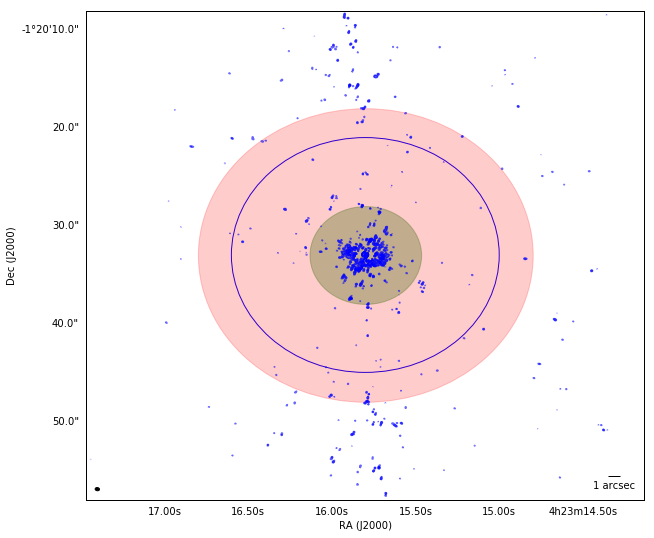

In [10]:
multp = np.array([3, 3.5, 4.5, 5, 5.5, 6, 10, 100, 1000])
center = [65.8158364, -1.3425182]
PB = 24.0/3600.0
maskradius = 5.0/3600.0
rmsregion = 'annulus.reg'

fitsfile = './images/uninjected.ms.withoutclean.cont.fits'
levels = 3.702660e-05*multp

plot_fits(fitsfile, levels, center, PB, maskradius, rmsregion)

#### Case 1: Without cleaning

#### Case 2: After cleaning without masking

#### Case 3: After cleaning with masking centered around central source

In [11]:
data = read_sexofile("./images/injected_clean_mask.cat")
select_data = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_BEST'], data['NUMBER'].astype('int')

Col names:  ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.190e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.329e-04 [aplpy.core]


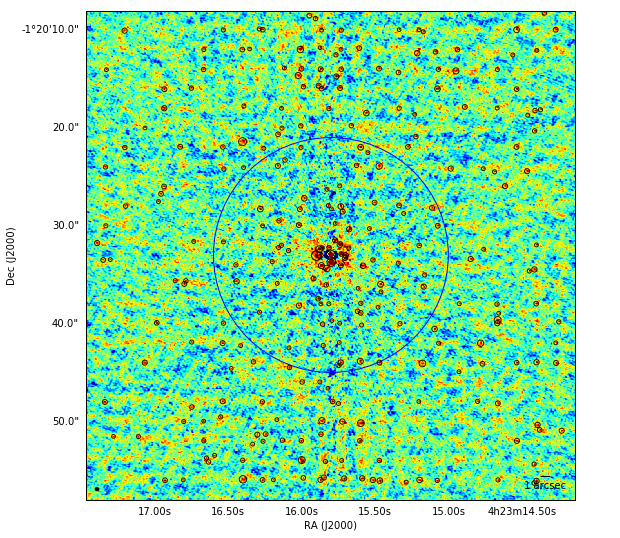

In [12]:
fitsfile = './images/injected.ms.afterclean.cont.fits'
levels = 3.742764e-05*multp

plot_fits(fitsfile, levels, center, PB, sourcelist=select_data, showcontour=False, showimage=True)

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]


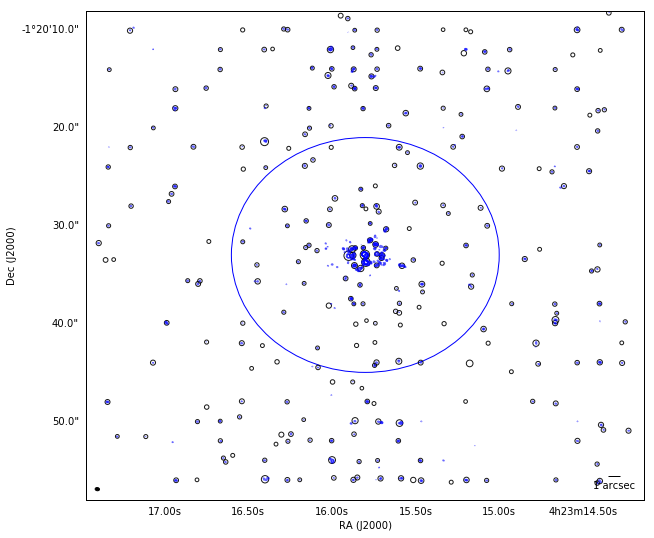

In [13]:
fitsfile = './images/injected.ms.afterclean.cont.fits'
levels = 3.742764e-05*multp

plot_fits(fitsfile, levels, center, PB, sourcelist=select_data)

<hr>
<hr>

### After first trial

+ I still a bit confused with <code>freq</code>, reference frequency used 
-> https://casa.nrao.edu/Release3.4.0/docs/casaref/componentlist.setfreq.html
-> https://help.almascience.org/index.php?/Knowledgebase/Article/View/86/0/what-are-the-frequency-reference-frames-in-casa
-> 
+ If we set it with a grid like that, does it produce some systematic-error that influence the completeness test? ---- Fourier tranform of evenly spaced point sources.
+ adding components is taking quite a lot of time in **uvsub** step. In the first test with number of sample:  576, it takes around 1 hour to complete uvsub -> I think it will also depend on the size of MS. Is the sample too many?
+ How to compute "Completeness Parameter (%)"?